In [1]:
import geostatspy.GSLIB as GSLIB                        # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats 

In [2]:
import numpy
numpy.__version__

'1.24.3'

In [3]:
import sys
#!{sys.executable} -m pip install --user numpy==1.21

In [4]:
import numpy as np                                      # ndarrys for gridded data
import pandas as pd                                     # DataFrames for tabular data
import os                                               # set working directory, run executables
import matplotlib.pyplot as plt                         # for plotting
from matplotlib.colors import ListedColormap            # custom color maps
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from scipy import stats                                 # summary statistics
import math                                             # trigonometry etc.
import scipy.signal as signal                           # kernel for moving window calculation
import random                                           # for randon numbers
import seaborn as sns                                   # for matrix scatter plots
from scipy import linalg                                # for linear regression
from sklearn import preprocessing                       # remove encoding error
from sklearn.feature_selection import RFE               # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression # mutual information
from sklearn.linear_model import LinearRegression       # linear regression model
from sklearn.ensemble import RandomForestRegressor      # model-based feature importance
from statsmodels.stats.outliers_influence import variance_inflation_factor # variance inflation factor
plt.rc('axes', axisbelow=True)                          # girds and axes behind all plot elements
cmap = plt.cm.inferno      

In [5]:
my_colormap = plt.cm.get_cmap('RdBu_r', 256)            # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))         # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])        # define white color (4 channel)
#newcolors[26:230, :] = white                           # mask all correlations less than abs(0.8)
#newcolors[56:200, :] = white                           # mask all correlations less than abs(0.6)
newcolors[76:180, :] = white                            # mask all correlations less than abs(0.4)
signif = ListedColormap(newcolors)                      # assign as listed colormap
  
my_colormap = plt.cm.get_cmap('inferno', 256)           # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))         # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])        # define white color (4 channel)
#newcolors[26:230, :] = white                           # mask all correlations less than abs(0.8)
newcolors[0:12, :] = white                              # mask all correlations less than abs(0.6)
#newcolors[86:170, :] = white                           # mask all correlations less than abs(0.4)
sign1 = ListedColormap(newcolors) 

/var/folders/m7/06_4f5012qg8t0w9k0bt0qy80000gn/T/ipykernel_29668/652844016.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_colormap = plt.cm.get_cmap('RdBu_r', 256)            # make a custom colormap
/var/folders/m7/06_4f5012qg8t0w9k0bt0qy80000gn/T/ipykernel_29668/652844016.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_colormap = plt.cm.get_cmap('inferno', 256)           # make a custom colormap


In [6]:
def partial_corr(C):                                    # partial correlation by Fabian Pedregosa-Izquierdo, f@bianp.net
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C):                                # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] 
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):                         # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def mutual_information_objective(x,y):                  # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

def delta_mutual_information_quotient(x,y):             # standard mutual information quotient
    delta_mutual_information_quotient = []               
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                          
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))                  
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

def weighted_avg_and_std(values, weights):              # calculate weighted statistics (Eric O Lebigot, stack overflow)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc):           # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):             # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

In [7]:
dataset = 0

if dataset == 0:
    df = pd.read_csv('ImputedValues.csv')               # load our data table
    #df = df.rename(columns={'Production':'Prod'})
    response = 'Avg Pump Difference'

    x = df.copy(deep = True); x = x.drop(response,axis='columns')
    Y = df.loc[:,response]
    
    pred = x.columns
    resp = Y.name
    
    xmin = [2300.0,15.0,0.0,695.83793,0.453435,7345.0,1824.858692]; xmax = [18200.0,998.0,9.0,3228.586918,0.638137019,10675.0,3579.913367]
    Ymin = -12.69; Ymax = 117.26
    
    predlabel = ['Lateral Length', 'Soak Time', 'PARENT_1050_WELL_COUNT', 'Avg Close Pressure', 
                 'Pressure Gradient (psi/ft) new', 'TVD', 'Avg Open Pressure']
    resplabel = 'Normalized Avg Pump Difference'
    
    predtitle = ['Lateral Length', 'Soak Time', 'PARENT_1050_WELL_COUNT', 'Avg Close Pressure', 
                 'Pressure Gradient (psi/ft) new', 'TVD', 'Avg Open Pressure']
    resptitle = 'Normalized Average Pump Difference'

In [8]:
df = df.dropna()
df.head()

,Avg Pump Difference,Area,Lateral Length,Fluid System,TVD,Development Strategy,DELAYED,BOUND_CODE,CODEV_POSITION,CODEV_FORMATION_POSITION,...,CODEV_3000_AVG_WELL_AGE,CODEV_3000_MEDIAN_WELL_AGE,CODEV_3000_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Open Pressure,SD Open Pressure,Avg Close Pressure,SD Close Pressure,Imputed
0,-0.93,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,Edge,...,0.0,0.0,1,0.593758,34,3304.124833,261.7,2719.898438,472.4,True
1,-8.45,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,Edge,...,0.0,0.0,1,0.597059,67,3301.199254,255.9,2934.885325,747.4,True
2,8.70,Arches,11000,Campbell,8470.0,Orange Crush,0,101111,Middle,Edge,...,4.5,0.0,11,0.516873,34,2774.407080,184.8,1589.948673,596.9,True
3,-2.68,Arches,11000,Campbell,10555.0,Coke,1,11110000,Edge,Edge,...,0.0,0.0,1,0.501287,30,2653.539415,206.7,1304.162878,551.5,True
4,19.93,Badlands,2300,Campbell,9295.0,Mountain Dew,1,10001101,Edge,Edge,...,1.0,1.0,2,0.503327,336,1824.858692,198.1,695.837930,363.4,True


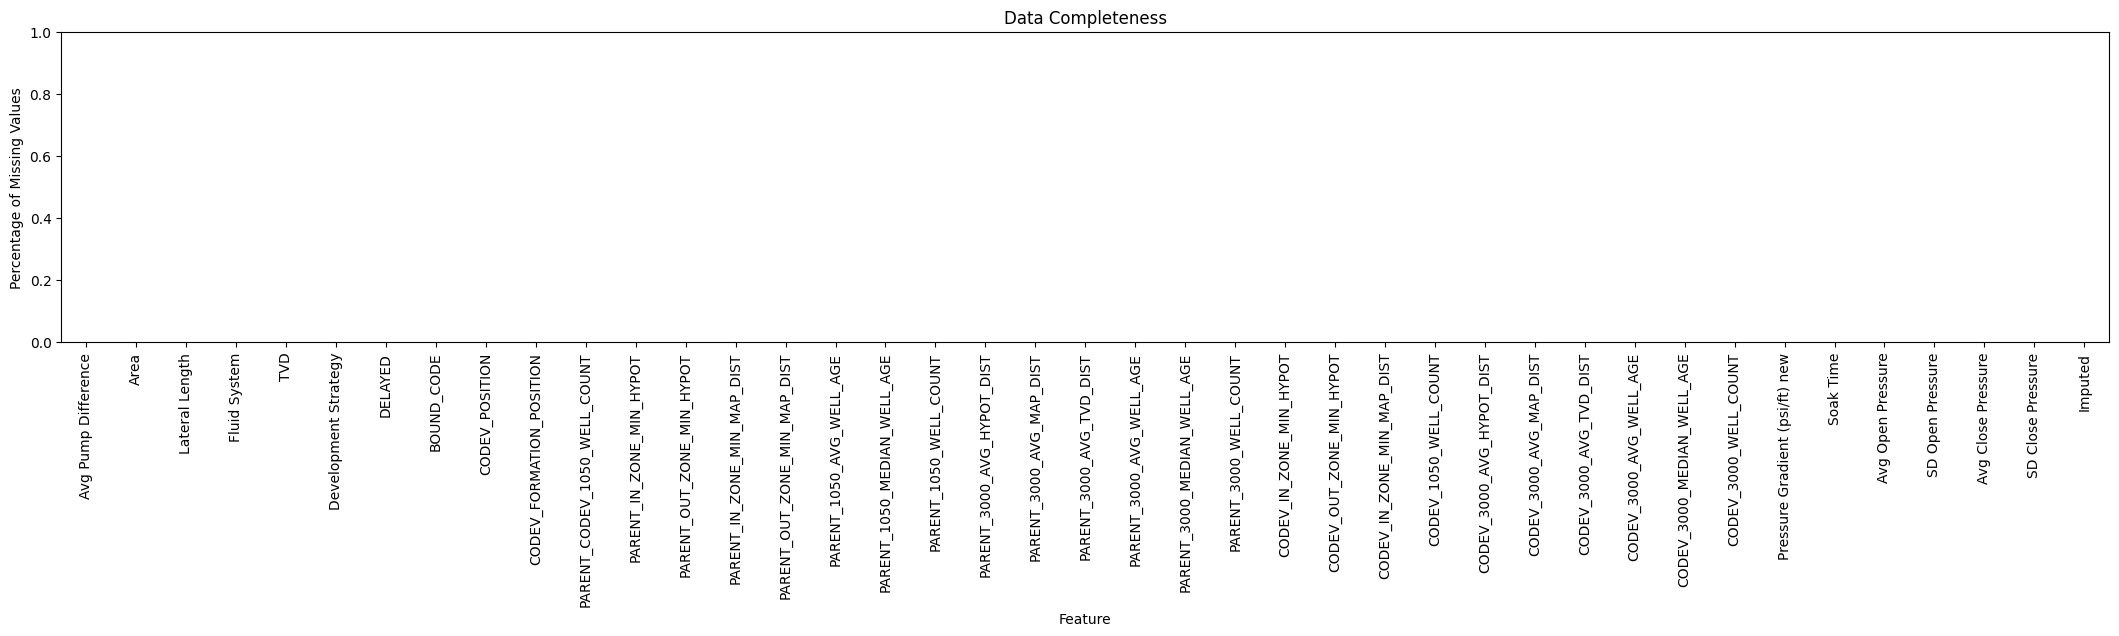

In [9]:
plt.subplot(311)
(df.isnull().sum()/len(df)).plot(kind = 'bar')          # calculate DataFrame with percentage missing by feature
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness'); plt.ylim([0.0,1.0])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

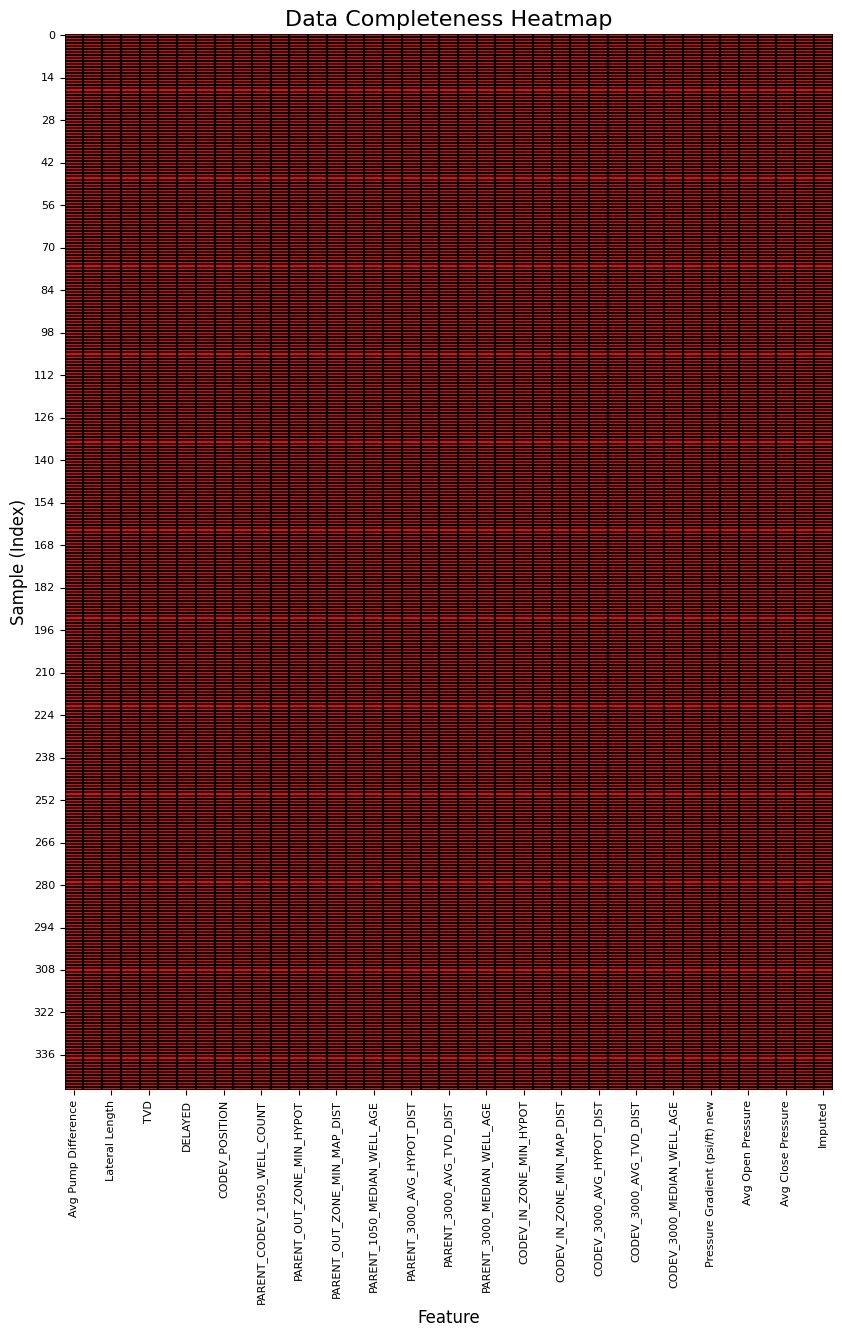

In [10]:
df_temp = df.copy(deep=True)                            # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.1) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

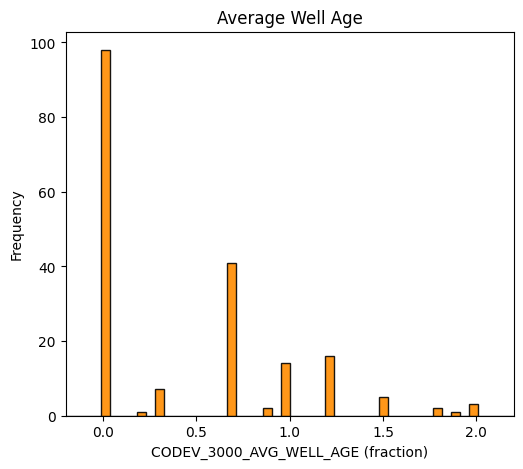

In [11]:
plt.subplot(111)
GSLIB.hist_st(df['CODEV_3000_AVG_WELL_AGE'].values,-.2,2.2,log=False,cumul = False,bins=50,weights = None,xlabel='CODEV_3000_AVG_WELL_AGE (fraction)',title='Average Well Age')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=0.8, wspace=0.1, hspace=0.2)
plt.show()

In [85]:
if dataset == 0:
    response = 'Avg Pump Difference'
    
    df2 = pd.DataFrame().assign()
    df2['LL'] = df['Lateral Length']
    df2['ST'] = df['Soak Time']
    df2['P#'] = df['PARENT_1050_WELL_COUNT']
    df2['C PSI'] = df['Avg Close Pressure']
    df2['PSI G'] = df['Pressure Gradient (psi/ft) new']
    df2['TVD'] = df['TVD']
    df2['Avg Pump Difference'] = df['Avg Pump Difference']

    x = df2.copy(deep = True); x = x.drop(response,axis='columns')
    Y = df.loc[:,response]
    
    features = x.columns.values.tolist() + [Y.name]
    pred = x.columns.values.tolist()
    resp = Y.name
    
    xmin = [2300.0,15.0,0.0,695.83793,0.453435,7345.0,1824.858692]; xmax = [18200.0,998.0,9.0,3228.586918,0.638137019,10675.0,3579.913367]
    Ymin = -12.69; Ymax = 117.26
    
    predlabel = ['Lateral L', 'Soak T', 'P1050_COUNT', 'Avg Close PSI', 
                 'PSI Grad.', 'TVD']
    resplabel = 'Normalized Avg Pump Difference'
    
    predtitle = ['Lateral L', 'Soak T', 'P1050_COUNT', 'Avg Close PSI', 
                 'PSI Grad.', 'TVD']
    resptitle = 'Normalized Average Pump Difference'
    
    featurelabel = predlabel + [resplabel]
    featuretitle = predtitle + [resptitle]

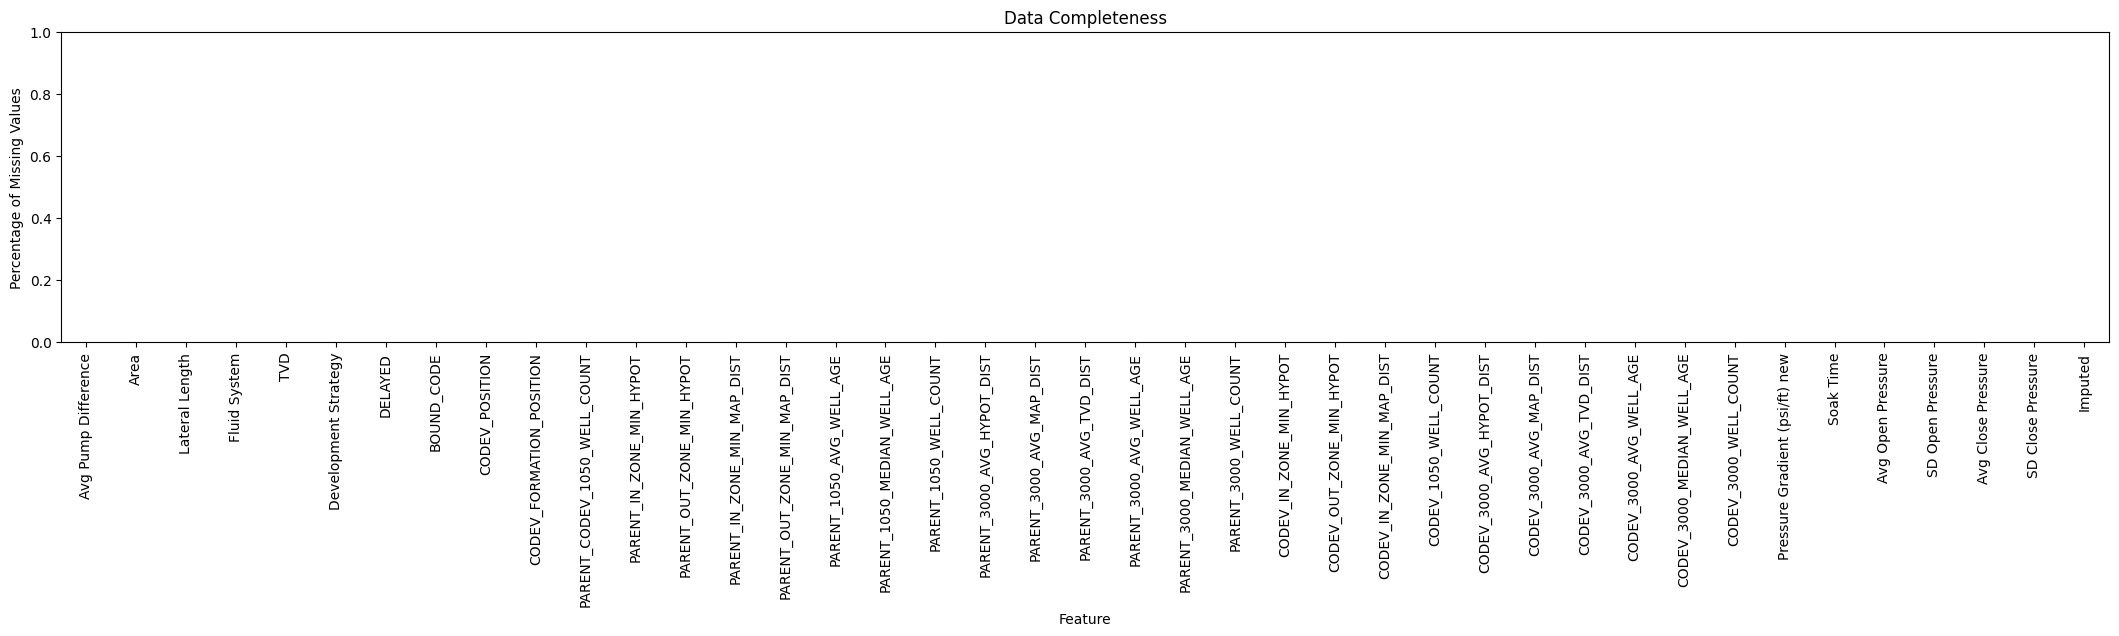

In [86]:
# Feature Coverage Works
plt.subplot(311)
(df.isnull().sum()/len(df)).plot(kind = 'bar')          # calculate DataFrame with percentage missing by feature
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness'); plt.ylim([0.0,1.0])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

In [87]:
partial_correlation = partial_corr(df2) # calculate the partial correlation coefficients
partial_correlation = partial_correlation[:,6][:6] # extract a single row and remove production with itself
print(partial_correlation)

[ 0.15208855 -0.01293325  0.07975149 -0.21053979 -0.22200882  0.36816845]


In [88]:
semipartial_correlation = semipartial_corr(df2) # calculate the semi-partial correlation coefficients
semipartial_correlation = semipartial_correlation[:,6][:6] # extract a single row and remove production with itself
print(semipartial_correlation)

[ 0.04906358 -0.03727905  0.0604559  -0.28247904 -0.44687667  0.10325333]


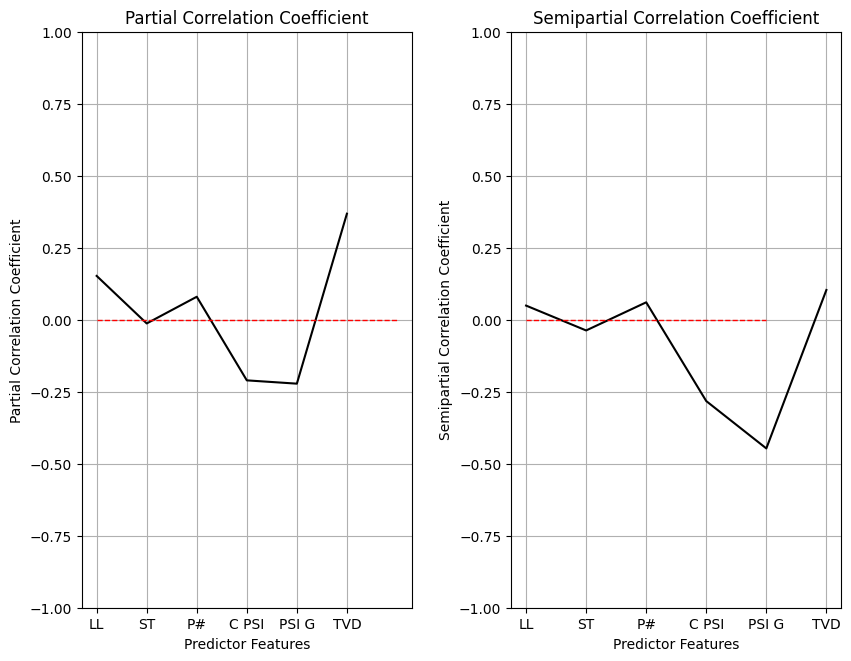

In [89]:
plt.subplot(154)
plt.plot(pred,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(pred,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0],'r--',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)

plt.show()